In [2]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# read files and transform variables
covid_df = pd.read_csv(r'WHO-COVID-19-global-data.csv', sep = ',',
                      header = 0, keep_default_na=False, na_values=[''], encoding = 'ISO-8859-1')

population_df = pd.read_csv(r'UN_PopulationData.csv', sep = ',',
                      header = 0, keep_default_na=False, na_values=[''], encoding = 'ISO-8859-1')
population_df['Population_Total'] = 1000 * population_df['Population_Total']

healthspend_df = pd.read_csv(r'WHO_HealthcareSpending_PercentGDP.csv', sep = ',',
                      header = 0, keep_default_na=False, na_values=[''], encoding = 'ISO-8859-1')
healthspend_df['2017_Health_Spend_%GDP'] = healthspend_df['2017_Health_Spend_%GDP'] / 100

respiratorydeaths_df = pd.read_csv(r'WHO_Respiratory_Deaths.csv', sep = ',',
                      header = 0, keep_default_na=False, na_values=[''], usecols = [0, 2, 3, 4, 5],
                      encoding = 'ISO-8859-1')

IHRcompliance_df = pd.read_csv(r'WHO_InternationalHealthRegulations_CoreCapacityScores_SPARv.csv', sep = ',',
                      header = 0, keep_default_na=False, na_values=[''], encoding = 'ISO-8859-1')

# create df with filtered 'Date_reported' variable
cumulative_covid_df = covid_df.loc[covid_df['Date_reported'] == '2020-06-23T00:00:00Z']

# merge dataframes using outer left join (dataframe shapes not the same)
# cumulative_covif_df designated as left
join_covid_df = cumulative_covid_df.set_index('Country').join(
    [df.set_index('Country') for df in (population_df, healthspend_df, respiratorydeaths_df, IHRcompliance_df)]).reset_index()
merged_covid_df = join_covid_df.drop(['Date_reported', 'Country_code'], axis = 1)

# impute missing values using MICE
from fancyimpute import IterativeImputer

mice_impute = IterativeImputer()

cols_noimpute = ['Country', 'WHO_region',]
cols_impute = [x for x in list(merged_covid_df) if x not in cols_noimpute]
cols_impute_df = merged_covid_df[cols_impute].values
imputed = mice_impute.fit_transform(cols_impute_df)
imputed_covid_df = pd.DataFrame(imputed, columns = cols_impute, index = merged_covid_df.index)
merged_covid_df[cols_impute] = imputed_covid_df

# create new variables by performing scalar operations on existing variables using DataFrame.eval()

# ratio of total deaths per total cases
merged_covid_df.eval('Death_Case_Ratio = (Cumulative_deaths / Cumulative_cases)', inplace = True)

# crude covid mortality rate
merged_covid_df.eval('Covid_Mortality_per_100k = (Cumulative_deaths / Population_Total) * 100000', inplace = True)

# Case rate per population
merged_covid_df.eval('Covid_Cases_per_100k = (Cumulative_cases / Population_Total) * 100000', inplace = True)

# crude overall respiratory illness mortality rate (not including covid)
merged_covid_df.eval('Overall_Respiratory_Mortality_per_100k = (Overall_Respiratory_Disease_Deaths / Population_Total) * 100000', inplace = True)

# crude influenza mortality rate
merged_covid_df.eval('Influenza_Mortality_per_100k = (Influenza_Deaths / Population_Total) * 100000', inplace = True)

# crude pneumonia mortality rate
merged_covid_df.eval('Pneumonia_Mortality_per_100k = (Pneumonia_Deaths / Population_Total) * 100000', inplace = True)

# crude chronic lower respiratory illness mortality rate
merged_covid_df.eval('ChronicLowerRespiratory_Mortality_per_100k = (ChronicLowerRespiratory_Deaths / Population_Total) * 100000', inplace = True)

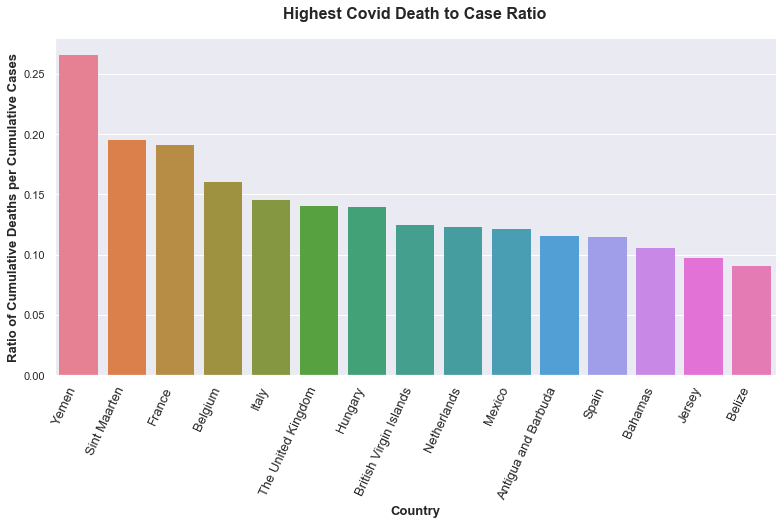

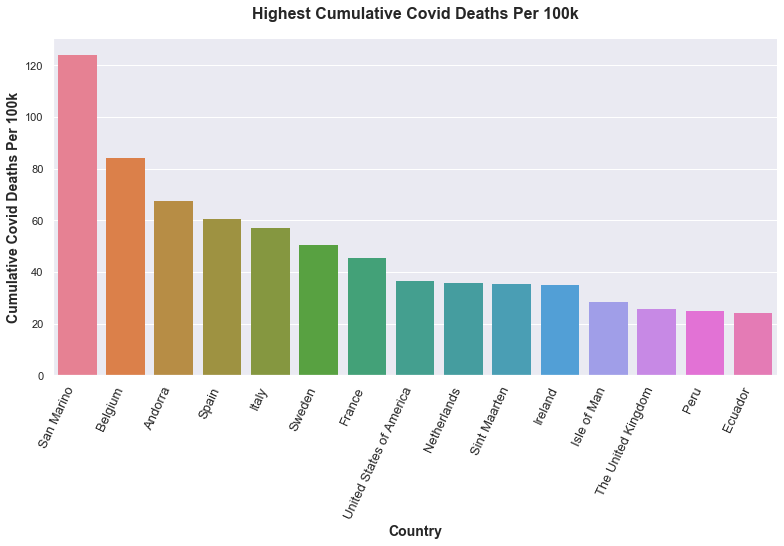

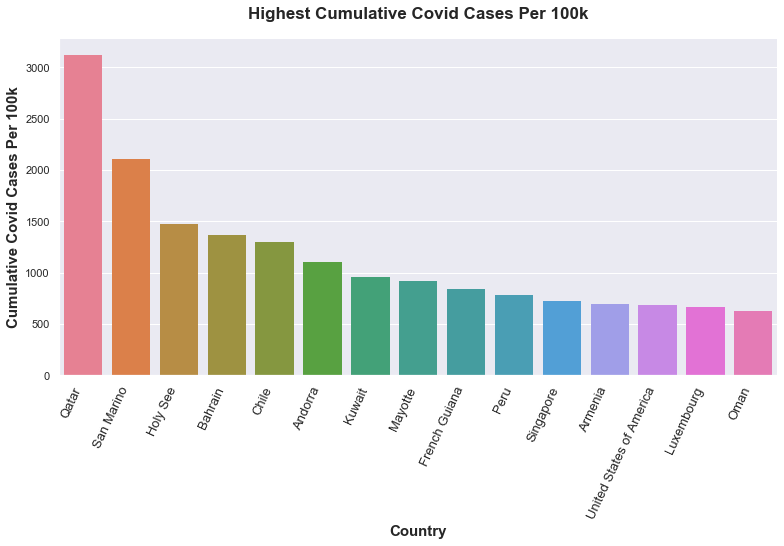

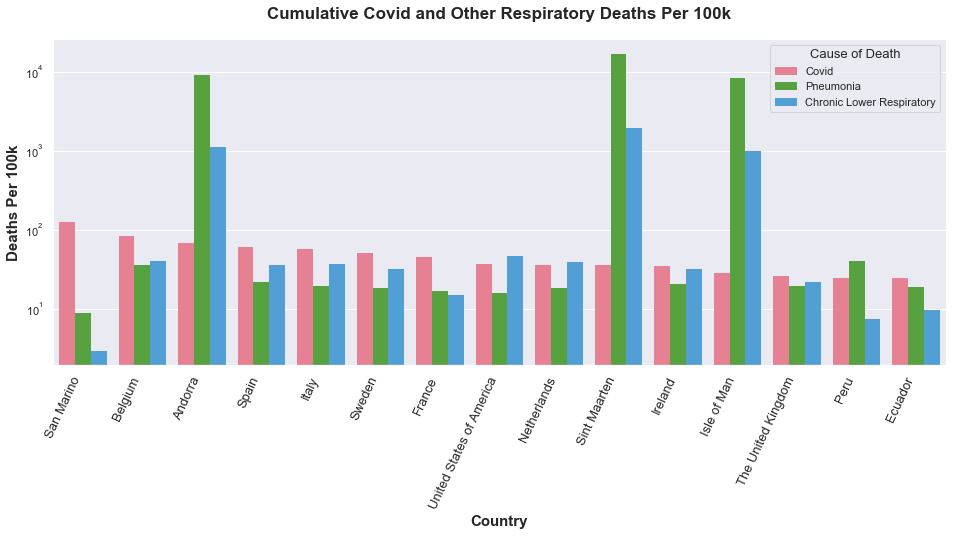

In [3]:
# filter top 15 countries and create new dataframes for visualization
top15_death_ratio_df = merged_covid_df.nlargest(15, ['Death_Case_Ratio'])
top15_deathsper100k_df = merged_covid_df.nlargest(15, ['Covid_Mortality_per_100k'])
top15_casesper100k_df = merged_covid_df.nlargest(15, ['Covid_Cases_per_100k'])

# plot the 15 countries with the highest death to case ratio
top15_covid_death_ratio = sns.catplot(x = 'Country', y = 'Death_Case_Ratio', kind = 'bar', palette = 'husl',
                                         linewidth = 0, data = top15_death_ratio_df, height = 5.5, aspect = 2)

plt.xticks(rotation = 65, horizontalalignment='right', fontsize = 13)
plt.title('Highest Covid Death to Case Ratio', weight = 'bold', fontsize = 16, pad = 20)
plt.xlabel('Country',  weight = 'bold', fontsize = 13)
plt.ylabel('Ratio of Cumulative Deaths per Cumulative Cases', weight = 'bold', fontsize = 13)


plt.show()


# plot the 15 countries with the highest cumulative covid crude death rate
top15_covid_mortality_per100k = sns.catplot(x = 'Country', y = 'Covid_Mortality_per_100k', kind = 'bar', palette = 'husl',
                                         linewidth = 0, data = top15_deathsper100k_df, height = 5.5, aspect = 2)

plt.xticks(rotation = 65, horizontalalignment='right', fontsize = 13)
plt.title('Highest Cumulative Covid Deaths Per 100k', weight = 'bold', fontsize = 16, pad = 20)
plt.xlabel('Country', weight = 'bold', fontsize = 14)
plt.ylabel('Cumulative Covid Deaths Per 100k', weight = 'bold', fontsize = 14)


plt.show()


# plot the 15 countries with the highest cumulative covid case rate
top15_covid_cases_per100k = sns.catplot(x = 'Country', y = 'Covid_Cases_per_100k', kind = 'bar', palette = 'husl',
                                         linewidth = 0, data = top15_casesper100k_df, height = 5.5, aspect = 2)

plt.xticks(rotation = 65, horizontalalignment='right', fontsize = 13)
plt.title('Highest Cumulative Covid Cases Per 100k', weight = 'bold', fontsize = 17, pad = 20)
plt.xlabel('Country', weight = 'bold', fontsize = 15)
plt.ylabel('Cumulative Covid Cases Per 100k', weight = 'bold', fontsize = 15)

plt.show()


# plot the 15 countries with the highest cumulative death rate and corresponding deaths due to respiratory illness
top15_covid_mortalityandrespdeaths_per100k_melt = pd.melt(top15_deathsper100k_df, id_vars = ['Country'],
                                            value_vars = ['Covid_Mortality_per_100k', 
                                                        'Pneumonia_Mortality_per_100k',
                                                         'ChronicLowerRespiratory_Mortality_per_100k'], var_name = 'Deaths')
fig, ax = plt.subplots(figsize = (16,6))

top15_covid_mortalityandrespdeaths_per100k = sns.barplot(x = 'Country', y = 'value', hue = 'Deaths', 
                                                         data = top15_covid_mortalityandrespdeaths_per100k_melt, 
                                                         linewidth = 0, palette = 'husl')

plt.xticks(rotation = 65, horizontalalignment='right', fontsize = 13)
plt.title('Cumulative Covid and Other Respiratory Deaths Per 100k', weight = 'bold', fontsize = 17, pad = 20)
plt.xlabel('Country', weight = 'bold', fontsize = 15)
plt.ylabel('Deaths Per 100k', weight = 'bold', fontsize = 15)

labels = ['Covid', 'Pneumonia', 'Chronic Lower Respiratory']

h, l = top15_covid_mortalityandrespdeaths_per100k.get_legend_handles_labels()
top15_covid_mortalityandrespdeaths_per100k.legend(h, labels, title = 'Cause of Death', title_fontsize = 13)

top15_covid_mortalityandrespdeaths_per100k.set(yscale = 'log')

plt.show()

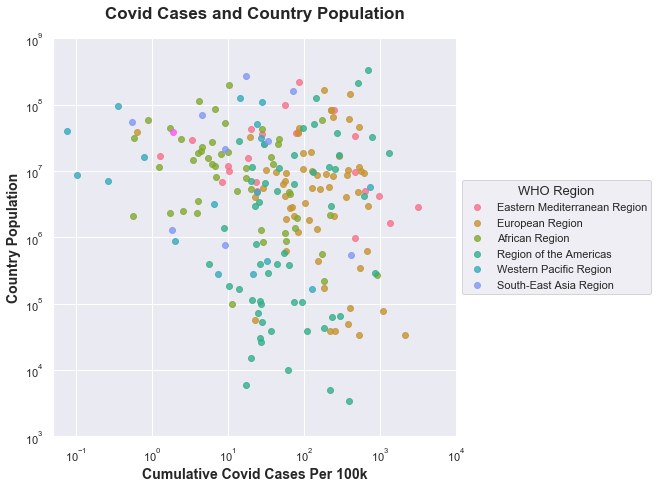

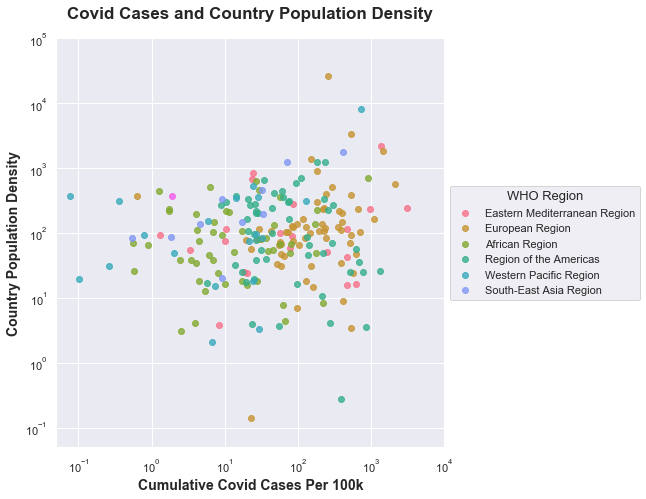

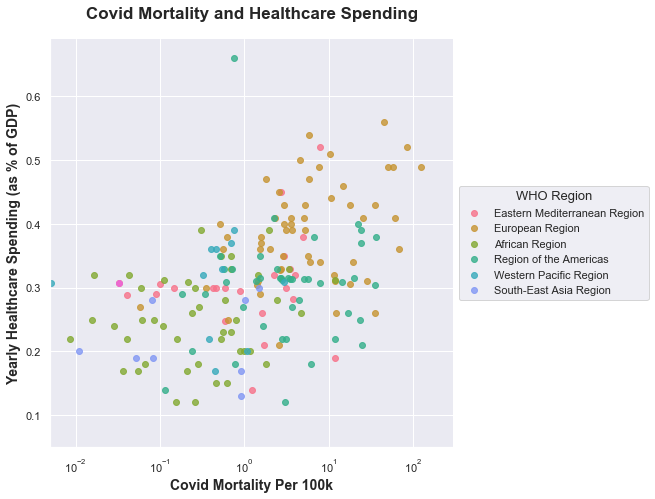

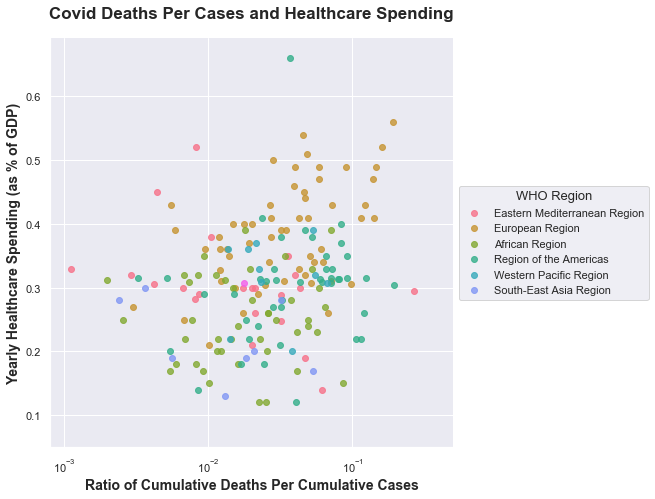

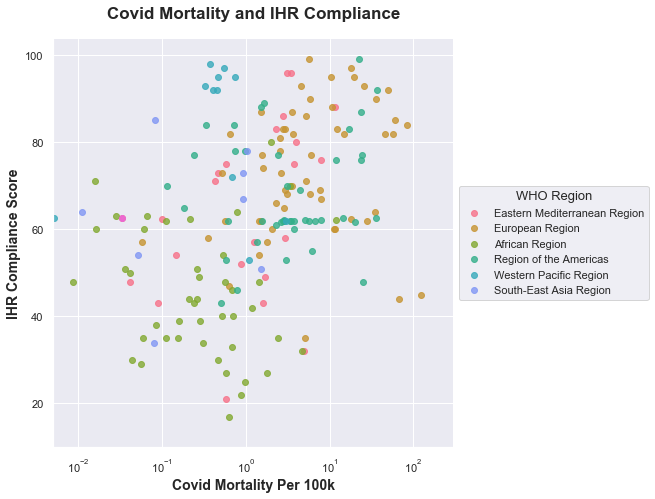

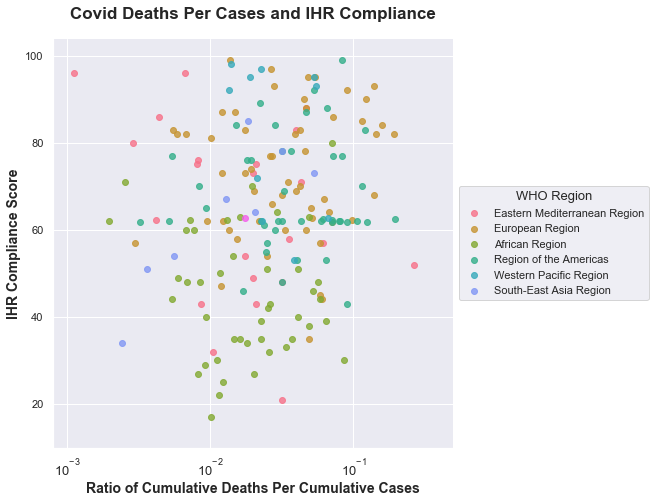

In [4]:
# create lmplots to explore relationships between variables

# create lmplot to look at relationship between cumulative covid cases and population
covid_cases_population = sns.lmplot(x = 'Covid_Cases_per_100k', y = 'Population_Total', fit_reg = False, 
                                    hue = 'WHO_region', palette = 'husl', legend = False, data = merged_covid_df, 
                                    height = 6.5, aspect = 1)

plt.title('Covid Cases and Country Population', weight = 'bold', fontsize = 17, pad = 20)
plt.xlabel('Cumulative Covid Cases Per 100k', weight = 'bold', fontsize = 14)
plt.ylabel('Country Population', weight = 'bold', fontsize = 14)
plt.legend(title = 'WHO Region', title_fontsize = 13, loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1, 
                              labels = ['Eastern Mediterranean Region', 'European Region', 'African Region',
                                      'Region of the Americas', 'Western Pacific Region', 'South-East Asia Region'])

axes = covid_cases_population.axes
axes[0,0].set_xlim(0.05,10000)
axes[0,0].set_ylim(1000,1000000000)
covid_cases_population.set(xscale = 'log')
covid_cases_population.set(yscale = 'log')

plt.show()


# create lmplot to look at relationship between cumulative covid cases and population density
covid_cases_population_density = sns.lmplot(x = 'Covid_Cases_per_100k', y = 'Population_Density', fit_reg = False, 
                                    hue = 'WHO_region', palette = 'husl', legend = False, data = merged_covid_df, 
                                    height = 6.5, aspect = 1)

plt.title('Covid Cases and Country Population Density', weight = 'bold', fontsize = 17, pad = 20)
plt.xlabel('Cumulative Covid Cases Per 100k', weight = 'bold', fontsize = 14)
plt.ylabel('Country Population Density', weight = 'bold', fontsize = 14)
plt.legend(title = 'WHO Region', title_fontsize = 13, loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1, 
                              labels = ['Eastern Mediterranean Region', 'European Region', 'African Region',
                                      'Region of the Americas', 'Western Pacific Region', 'South-East Asia Region'])

axes = covid_cases_population_density.axes
axes[0,0].set_xlim(0.05,10000)
axes[0,0].set_ylim(0.05,100000)
covid_cases_population_density.set(xscale = 'log')
covid_cases_population_density.set(yscale = 'log')

plt.show()


# create lmplot to look at relationship between cumulative covid mortality and healthcare spending as % of GDP
covid_mortality_health_spend = sns.lmplot(x = 'Covid_Mortality_per_100k', y = '2017_Health_Spend_%GDP', fit_reg = False, 
                                    hue = 'WHO_region', palette = 'husl', legend = False, data = merged_covid_df, 
                                    height = 6.5, aspect = 1)

plt.title('Covid Mortality and Healthcare Spending', weight = 'bold', fontsize = 17, pad = 20)
plt.xlabel('Covid Mortality Per 100k', weight = 'bold', fontsize = 14)
plt.ylabel('Yearly Healthcare Spending (as % of GDP)', weight = 'bold', fontsize = 14)
plt.legend(title = 'WHO Region', title_fontsize = 13, loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1,
                              labels = ['Eastern Mediterranean Region', 'European Region', 'African Region',
                                      'Region of the Americas', 'Western Pacific Region', 'South-East Asia Region'])

axes = covid_mortality_health_spend.axes
axes[0,0].set_xlim(0.005,300)
axes[0,0].set_ylim(0.05,)
covid_mortality_health_spend.set(xscale = 'log')

plt.show()

# create lmplot to look at relationship between death to case ratio and healthcare spending as % of GDP
covid_ratio_health_spend = sns.lmplot(x = 'Death_Case_Ratio', y = '2017_Health_Spend_%GDP', fit_reg = False, 
                                    hue = 'WHO_region', palette = 'husl', legend = False, data = merged_covid_df, 
                                    height = 6.5, aspect = 1)

plt.title('Covid Deaths Per Cases and Healthcare Spending', weight = 'bold', fontsize = 17, pad = 20)
plt.xlabel('Ratio of Cumulative Deaths Per Cumulative Cases', weight = 'bold', fontsize = 14)
plt.ylabel('Yearly Healthcare Spending (as % of GDP)', weight = 'bold', fontsize = 14)
plt.legend(title = 'WHO Region', title_fontsize = 13, loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1,
                              labels = ['Eastern Mediterranean Region', 'European Region', 'African Region',
                                      'Region of the Americas', 'Western Pacific Region', 'South-East Asia Region'])

axes = covid_ratio_health_spend.axes
axes[0,0].set_xlim(0.0008,0.5)
axes[0,0].set_ylim(0.05,)
covid_ratio_health_spend.set(xscale = 'log')

plt.show()

# create lmplot to look at relationship between cumulative covid mortality and WHO IHR compliance score
covid_mortality_IHRscore = sns.lmplot(x = 'Covid_Mortality_per_100k', y = '2019_IHR_Compliance_Score', fit_reg = False, 
                                    hue = 'WHO_region', palette = 'husl', legend = False, data = merged_covid_df, 
                                    height = 6.5, aspect = 1)

plt.title('Covid Mortality and IHR Compliance', weight = 'bold', fontsize = 17, pad = 20)
plt.xlabel('Covid Mortality Per 100k', weight = 'bold', fontsize = 14)
plt.ylabel('IHR Compliance Score', weight = 'bold', fontsize = 14)
plt.legend(title = 'WHO Region', title_fontsize = 13, loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1,
                              labels = ['Eastern Mediterranean Region', 'European Region', 'African Region',
                                      'Region of the Americas', 'Western Pacific Region', 'South-East Asia Region'])

axes = covid_mortality_IHRscore.axes
axes[0,0].set_xlim(0.005,300)
axes[0,0].set_ylim(10,)
covid_mortality_IHRscore.set(xscale = 'log')

plt.show()

# create lmplot to look at relationship between death to case ratio and WHO IHR compliance score
covid_ratio_IRHscore = sns.lmplot(x = 'Death_Case_Ratio', y = '2019_IHR_Compliance_Score', fit_reg = False, 
                                    hue = 'WHO_region', palette = 'husl', legend = False, data = merged_covid_df, 
                                    height = 6.5, aspect = 1)

plt.xticks(fontsize = 13)
plt.title('Covid Deaths Per Cases and IHR Compliance', weight = 'bold', fontsize = 17, pad = 20)
plt.xlabel('Ratio of Cumulative Deaths Per Cumulative Cases', weight = 'bold', fontsize = 14)
plt.ylabel('IHR Compliance Score', weight = 'bold', fontsize = 14)
plt.legend(title = 'WHO Region', title_fontsize = 13, loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1,
                              labels = ['Eastern Mediterranean Region', 'European Region', 'African Region',
                                      'Region of the Americas', 'Western Pacific Region', 'South-East Asia Region'])

axes = covid_ratio_IRHscore.axes
axes[0,0].set_xlim(0.0008,0.5)
axes[0,0].set_ylim(10,)
covid_ratio_IRHscore.set(xscale = 'log')

plt.show()

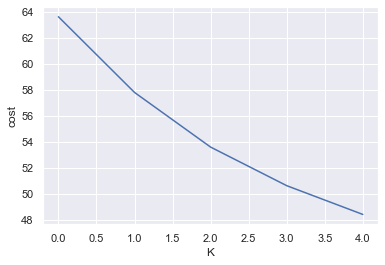

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/20, moves: 65, ncost: 59.21198816632343
Run: 1, iteration: 2/20, moves: 27, ncost: 58.18848796617525
Run: 1, iteration: 3/20, moves: 17, ncost: 57.89167871109819
Run: 1, iteration: 4/20, moves: 2, ncost: 57.877727015433464
Run: 1, iteration: 5/20, moves: 1, ncost: 57.876491270928675
Run: 1, iteration: 6/20, moves: 0, ncost: 57.876491270928675
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/20, moves: 111, ncost: 58.288522948433425
Run: 2, iteration: 2/20, moves: 23, ncost: 57.87905062335025
Run: 2, iteration: 3/20, moves: 3, ncost: 57.85466066812463
Run: 2, iteration: 4/20, moves: 2, ncost: 57.84570657501147
Run: 2, iteration: 5/20, moves: 1, ncost: 57.83517928455407
Run: 2, iteration: 6/20, moves: 1, ncost: 57.727472016809536
Run: 2, iteration: 7/20, moves: 0, ncost: 57.727472016809536
Init: initializing centroids
Init: initializing 

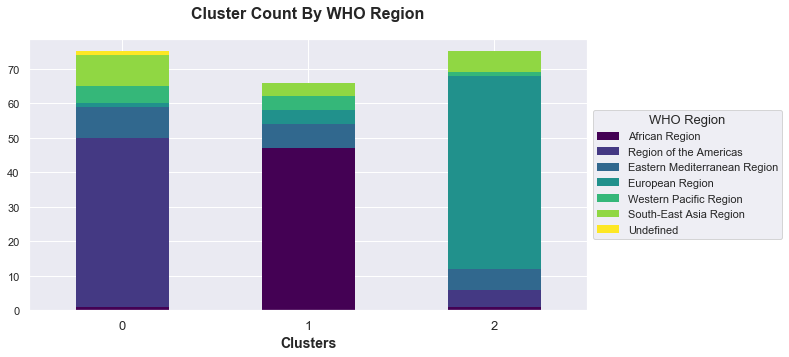

In [5]:
# segment the countries using agglomerative clustering

from sklearn import preprocessing
from kmodes.kprototypes import KPrototypes

# normalize data to eliminate bias
scaled_merged_covid_df = merged_covid_df.copy()

min_max_scaler = preprocessing.MinMaxScaler()
cols_nonorm = ['Country', 'WHO_region']
cols_norm = [x for x in list(scaled_merged_covid_df) if x not in cols_nonorm]
cols_norm_df = scaled_merged_covid_df[cols_norm].values
cols_norm_df_scaled = min_max_scaler.fit_transform(cols_norm_df)
scaled_covid_df = pd.DataFrame(cols_norm_df_scaled, columns = cols_norm, index = scaled_merged_covid_df.index)
scaled_merged_covid_df[cols_norm] = scaled_covid_df


# create new dataframe with dropped columns
kproto_df = scaled_merged_covid_df.drop(['Overall_Respiratory_Disease_Deaths', 'Influenza_Deaths', 'Pneumonia_Deaths', 
                                         'ChronicLowerRespiratory_Deaths'], axis = 1)


# calculate ideal number of Ks
cost = []
X = kproto_df
for num_clusters in list(range(2,7)):
    kproto = KPrototypes(n_clusters = num_clusters, init = 'Huang', max_iter = 20) 
    kproto.fit_predict(X, categorical = [0, 1])
    cost.append(kproto.cost_)

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show()


# run k-prototype model
kproto_array = kproto_df.values
kproto = KPrototypes(n_clusters = 3, init = 'Huang', verbose = 2, max_iter = 20)
clusters = kproto.fit_predict(kproto_array, categorical = [0, 1])

print(kproto.cluster_centroids_)

# create a dict for clusters
kproto_cluster_dict = []
for c in clusters:
    kproto_cluster_dict.append(c)
    
kproto_df['Cluster'] = kproto_cluster_dict

# plot results
kproto_plot = kproto_df.groupby(['WHO_region', 'Cluster']).size().reset_index().pivot(columns='WHO_region', index='Cluster', values=0)


kproto_plot.plot(kind ='bar', stacked=True, colormap = 'viridis', figsize = (10, 5), linewidth = 0)

plt.legend(title = 'WHO Region', title_fontsize = 13, loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1,
                              labels = ['African Region', 'Region of the Americas', 'Eastern Mediterranean Region', 
                                        'European Region', 'Western Pacific Region', 'South-East Asia Region', 'Undefined'])

plt.xticks(rotation = 360, fontsize = 13)
plt.title('Cluster Count By WHO Region', weight = 'bold', fontsize = 16, pad = 20)
plt.xlabel('Clusters', weight = 'bold', fontsize = 14)
plt.ylabel(None)
plt.show()

In [6]:
# build an XGBoost classifier

import pandas
import xgboost
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


# bin the categorical variables
merged_covid_df['Binned_Death_Case_Ratio'] = pd.cut(x = merged_covid_df['Death_Case_Ratio'], bins = [0, 0.1, 0.3, 0.6, 1], 
                                                    labels = ['0 to 0.1', '0.1 to 0.3', '0.3 to 0.6', 'more than 0.6'])
merged_covid_df['Binned_Death_Case_Ratio'] = merged_covid_df['Binned_Death_Case_Ratio'].astype(str)

# encode binned variables
label_encoder = LabelEncoder()
merged_covid_df['Encoded_Death_Case_Ratio'] = label_encoder.fit_transform(merged_covid_df['Binned_Death_Case_Ratio'])
merged_covid_df['Encoded_WHO_Region'] = label_encoder.fit_transform(merged_covid_df['WHO_region'])


# create new dataframe to be turned into array
xgboost_df = merged_covid_df.filter(['Encoded_WHO_Region', '2017_Health_Spend_%GDP', '2019_IHR_Compliance_Score', 
                             'Pneumonia_Mortality_per_100k', 'ChronicLowerRespiratory_Mortality_per_100k',
                             'Encoded_Death_Case_Ratio'], axis = 1)

# create array
xgboost_dataset = xgboost_df.values
X = xgboost_dataset[:,0:5]
Y = xgboost_dataset[:,5]

# build XGBoost model
seed = 7
test_size = 0.20
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)
Covid_model = xgboost.XGBClassifier()
Covid_model.fit(X_train, y_train)
print(Covid_model)

# make predictions and print accuracy of model
y_predict = Covid_model.predict(X_test)
predictions = [round(value) for value in y_predict]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Accuracy: 86.36%
